# Resolución de problemas tipo "stiff"

<ul id="top">
</ul>

In [1]:
using DifferentialEquations
using BenchmarkTools
using LinearAlgebra
using Plots

## 1 -  El problema del péndulo con muelle


Vamos a integrar numéricamente un problema de valor inicial que
corresponde a las ecuaciones del movimiento de un péndulo
formado por dos piezas unidas por un muelle que
se mueve en un plano vertical bajo la influencia de la fuerza de
la gravedad.



<img src="http://www.ehu.eus/ccwmuura/irakaskuntza/sinum/irudiak/pendulo.jpg" alt="pendulo" width="300" >




Este sistema mecánico tiene dos grados de libertad, y podemos
tomar como variables de posición del sistema el ángulo
$a$ y la distancia $L$ entre el punto de giro y el centro de
gravedad de la pieza inferior. Las ecuaciones del movimiento
correspondientes (bajo condiciones ideales de ausencia de
rozamiento) son las siguientes.

\begin{eqnarray*}
\frac{d^2}{dt^2} L &=& L \, \left(\frac{d a}{dt}\right)^2 + g \cos(a) - C_1 (L-L_0), \\
\frac{d^2}{dt^2} a &=& -\frac{g (C_2 + L) \sin(a) + 2 \, L \, \frac{d L}{dt}
\, \frac{d a}{dt}}{C_3 + L^2},
\end{eqnarray*}

donde $g$ es la aceleración de la gravedad, $L_0$ es el valor
de la distancia $L$ correspondiente al estado de reposo del
muelle,

\begin{eqnarray*}
C_1 = \frac{K}{m_2}, \quad C_2 = \frac{r m_1}{m_2}, \quad
C_3 = C_2 r + \frac{I_1+I_2}{m_2}, 
\end{eqnarray*}

$K$ es una constante determinada por la rigidez 
del muelle, $m_1$ y $m_2$ son
respectivamente las masas de la pieza superior e inferior,
$I_1$ e $I_2$ son los momentos de inercia de cada una de las
piezas respecto a su centro de gravedad, y $r$ es la distancia
entre el punto de giro y el centro de gravedad de la pieza
superior.

  Vamos a considerar el caso en que $L_0=1$, 
$g=1$, y las constantes $r$, $m_i,I_i$ (i=1,2) 
son tales que $C_2=1$ y $C_3=1$. Dependiendo de la rigidez del
muelle (dada por la constante $K$), se tendrán distintos
valores de la constante $C_1$. Consideraremos dos casos, que de
menor a mayor rigidez del muelle, serán $C_1 = 100$ y $C_1 = 10000$. En el segundo caso, tendremos un problem de EDOs de tipo "stiff".


Queremos
resolver el problema de valor inicial correspondiente a

$$
a(0)=\pi/2, \quad 
%d(0)=1+10^{-6} g \cos a(0), 
L(0)=L_0, 
\quad \frac{d}{dt} a(0)=0, \quad  \frac{d}{dt} L(0)=0,
$$

en el intervalo $t\in[0,40]$. 


A diferencia de las tareas de las semanas anteriores, en lugar de utilizar nuestras propias implementaciones de dichos algoritmos, utilizaremos la implementación disponibles en el paquete de resolución numérica de sistemas de EDOs disponible en Julia (DifferentialEquations.jl):

Haremos uso de dos algoritmos de integración numérica de sistemas de EDOs:
1. Una implementación de paso variable del método de Runge-Kutta de orden 5 de Dormand y Prince, DP5 (La función DOPRI5 implementada en la semana 5 es una versión simplificada de la misma.)
2. El método implícito de RK de orden 5 de Hairer (Hairer5), que como en el caso del método de Radau de orden 5 mostrado en las transparencias del Tema 4, es un **método apropiado para problems de tipo "stiff".**

Para ello, se ha de llamar a la función solve(), indicándole el método a utilizar (DP5() of Hairer5()), y la tolerancia absoluta (abstol) y tolerancia relativa (reltol) al error local. 
Los algoritmos a utilizar emplean una discretización temporal no uniforme adaptada al problema.

En todas las pruebas que hagamos con los distintos integradores,
variaremos la precisión de la integración variando el valor
de $tol$, y tomando tanto 'abstol' como 'reltol' igual a $tol$.

## 2 - Definición del sistema de EDOs

-  Para empezar, hay que escribir el sistema de arriba como un sistema de EDOs de primer orden de la forma du/dt = f(t,u, p), y posteriormente, **definir en Julia la función fmuelle(u,p,t) tal que f(t,u,p) = fmuelle(u, p, t).**

\begin{eqnarray*}
\frac{d^2}{dt^2} L &=& L \, \left(\frac{d a}{dt}\right)^2 + g \cos(a) - C_1 (L-L_0), \\
\frac{d^2}{dt^2} a &=& -\frac{g (C_2 + L) \sin(a) + 2 \, L \, \frac{d L}{dt}
\, \frac{d a}{dt}}{C_3 + L^2},
\end{eqnarray*}

El sistema de arriba escrito como un sistema de EDOs de primer orden de la forma du/dt = f(t,u, p)

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    L \\ a \\v_L \\ v_a
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_L\\
 v_a\\
 \displaystyle L \, (v_a)^2 + g \cos(a) - C_1 (L-L_0)\\ 
 \displaystyle -\frac{g (C_2 + L) \sin(a) + 2 \, L \, v_L
\, v_a}{C_3 + L^2}\\ 
  \end{matrix}
\right).
    \end{align*}

In [2]:
function fmuelle(u,p,t)
    
    g  = p[1]
    L0 = p[2]
    C  = p[3:5]
    
    L  = u[1]
    a  = u[2]
    dL = u[3]
    da = u[4]
    
    aux1 = L*(da)^2 + g*cos(a) - C[1]*( L - L0 )
    aux2 = - ( ( g*( C[2] + L ) *sin(a) + 2*L*dL*da ) / ( C[3] + L^2 ) )
    
    return [dL,da,aux1,aux2]
end

fmuelle (generic function with 1 method)

- **Evaluar dicha función para fmuelle(u,p,0.), donde u es el vector de estados correspondiente a los valores $a=1$, $L=2$, $da/dt=3$, $dL/dt=4$, y p es el vector de parámetros constantes correspondiente a $g=5$, $L_0=6$, $C_1=7$,  $C_2=8$,  $C_3=9$.** (Hay que tener en cuenta que las componentes de u y de p deben ser números de coma flotante, y no números enteros.)

In [3]:
p = [5.,6.,7.,8.,9.]
u = [1.,2.,3.,4.]
t = 0

fmuelle(u,p,t)

4-element Array{Float64,1}:
  3.0              
  4.0              
 48.91926581726429 
 -6.491838420715567

> **Comprobación**
> Debería de obtenerse

          4-element Array{Float64,1}:
          3.0              
          4.0              
          48.91926581726429 
          -6.491838420715567

<a href="#top">Back to the top</a>

## 3 - Muelle menos rígido ($C_1 = 100$)

Supongamos que queremos estudiar la evolución de las variables de estado del péndulo con muelle para $C_1=100$, en el intervalo temporal $(0,40)$, y que no nos hace falta mucha precisión en los resultados. Para disminuir el tiempo de CPU, aplicaremos el método DP5 con tol=$10^{-4}$.

- **Para comenzar, antes de aplicar la función _solve_, hay que definir el problema.**


In [4]:
u0= [1.,pi/2,0.,0.]
p= [1.,1.,100,1,1]
tspan = (0.0,40.0)
prob = ODEProblem(fmuelle,u0,tspan,p);

 - **Aplicar DP5 con $tol=10^{-4}$, y representar gráficamente la evolución de las variables de estado con respecto del tiempo.**

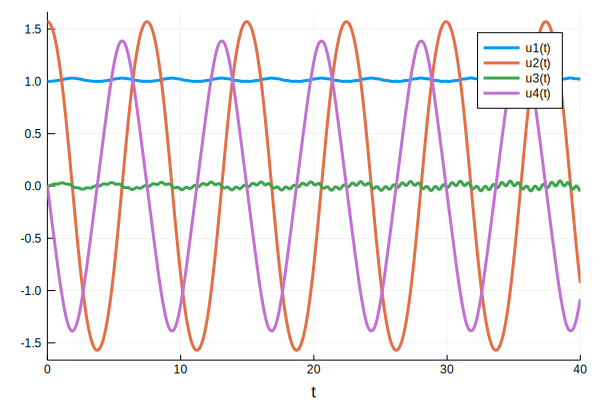

In [5]:
tol = 1e-4
sol = solve(prob,DP5(),reltol=tol, abstol= tol)

plot(sol)

- El algoritmo implementado en DP5() calcula las soluciones en una discretización del tiempo no uniforme. **Representar gráficamente la secuencia de longitudes de paso utilizadas a lo largo del intervalo temporal $[0,40]$.**  

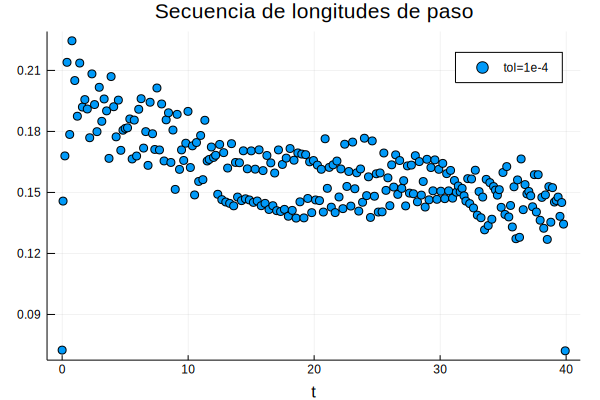

In [6]:
tt = sol.t
hh = diff(sol.t)
plot(tt[1:end-1],hh,title="Secuencia de longitudes de paso", xlabel="t", label="tol=1e-4", 
     seriestype=:scatter)

- Para comprobar la precisión de los resultados, **volver a aplicar DP5() al problema, pero esta vez con tol=$10^{-8}$.** Ahora, los resultados los calcula para otra discretización temporal no uniforme (más fina que la anterior, es decir, con más valores de los tiempos). **Para comprobarlo, comparar el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$.**

In [7]:
tol2 = 1e-8
sol2 = solve(prob,DP5(),reltol=tol2, abstol= tol2)
p1 = length(sol.t)
p2 = length(sol2.t)
println(p1)
println(p2)

252
1112


>Número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=1e-4:
**$252$**
>Número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=1e-8:
**$1112$**


>**Comprobación**
>  
> En el caso tol=1e-4, resulta una discretización temporal con 252 valores del tiempo, 
> y en el caso tol=1e-8, en cambio, 1112. 

 - Consideraremos los resultados recién obtenidos como exactos (pues se supone que son mucho más precisos que los obtenidos con tol=$10^{-4}$). Hay que tener en cuenta que, aunque en cada uno de los dos casos (_sol_ para la solución numérica menos precisa, y _sol2_ para la solución "exacta") calcula los resultados para discretizaciones temporales distintas, se pueden calcular los valores "exactos" de las variables de estado en cualquier valor de $t$ dentro del intervalo temporal $[0,40]$. Para ello, basta con poner sol2(t) (el algoritmo aplica técnicas de interpolación para calcular una aproximación del vector de estados en t).
 **Como comprobación adicional, calcular los valores "exactos" de las variables de estado en $t=14.5$.**  

In [8]:
sol2(14.5)

4-element Array{Float64,1}:
  1.0030050443733258  
  1.464208727048361   
 -0.016590545719418526
  0.4602876475898805  

>**Comprobación**
>  
> Se deberían de obtener los siguientes valores de las variables de estado
>

           1.0030050443733272  
           1.4642087270483626  
          -0.016590545719411362
           0.4602876475898731                                 

 
 - **Definir una función errfun(t) que calcule la norma de los errores cometidos en el caso de tol=$10^{-4}$ en el tiempo t. Representar gráficamente la evolución de dicha norma de los errores en los tiempos de la discretización temporal de los resultados obtenidos para tol=$10^{-4}$.**

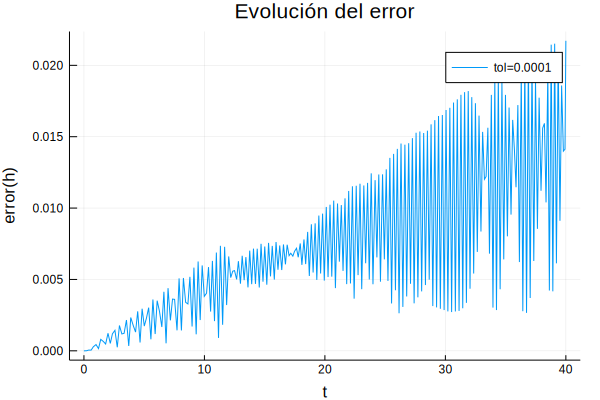

In [9]:
errfun(t) = norm(sol2(t)-sol(t))

err = zeros(length(sol.t),1)
for ix in 1:length(sol.t)
    err[ix] = errfun(sol.t[ix])
end

plot(sol.t,err,xlabel="t",ylabel="error(h)",label="tol=$tol",title="Evolución del error")

- **Utilizar @btime para medir y comparar los tiempos de ejecución para los resultados obtenidos con tol=$10^{-4}$ y con tol=$10^{-8}$ respectivamente.**

In [10]:
@btime solve(prob,DP5(),reltol=1e-4, abstol= 1e-4)

  1.376 ms (35781 allocations: 3.12 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 252-element Array{Float64,1}:
  0.0                
  0.07247796636776954
  0.21822600489423036
  0.3861881098967914 
  0.6001682681358695 
  0.7786720019746032 
  1.0032350249110225 
  1.2082551232091385 
  1.3957364064829338 
  1.609355745924366  
  1.8013457982923542 
  1.9970084346374264 
  2.1880374476582425 
  ⋮                  
 38.50362977132501   
 38.630533798299226  
 38.783389066680414  
 38.91875432772563   
 39.071114700091044  
 39.21638254213791   
 39.362443034268665  
 39.510155646541676  
 39.64840362553022   
 39.79344777383227   
 39.927875285489804  
 40.0                
u: 252-element Array{Array{Float64,1},1}:
 [1.0, 1.5708, 0.0, 0.0]                    
 [1.0, 1.56817, 0.0001854, -0.0724777]      
 [1.00024, 1.54699, 0.00409472, -0.218166]  
 [1.00171, 1.49628, 0.0135923, -0.385389]   
 [1.00539, 1.39126, 0.0185875, -0.595455]   
 [1.00867, 1.26966, 0.0189758, -0.765983]   
 [1.0138

In [11]:
@btime solve(prob,DP5(),reltol=1e-8, abstol= 1e-8)

  5.683 ms (138143 allocations: 12.07 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 1112-element Array{Float64,1}:
  0.0                 
  0.011486983549970353
  0.034577497818003546
  0.06266081218482743 
  0.09626729803326024 
  0.13363892074547612 
  0.1792073472464019  
  0.21735345638047773 
  0.25318327150663794 
  0.2865906592719644  
  0.31844715395020856 
  0.34926309080796747 
  0.3795379699111026  
  ⋮                   
 39.610084866897296   
 39.6485927414974     
 39.69096820276215    
 39.72826491139678    
 39.76429131072482    
 39.799203147030155   
 39.834232184715006   
 39.87041056869429    
 39.90983158429432    
 39.95495870641486    
 39.99458846845318    
 40.0                 
u: 1112-element Array{Array{Float64,1},1}:
 [1.0, 1.5708, 0.0, 0.0]                    
 [1.0, 1.57073, 7.57358e-7, -0.011487]      
 [1.0, 1.5702, 2.05473e-5, -0.0345775]      
 [1.0, 1.56883, 0.000120622, -0.0626607]    
 [1.00001, 1.56616, 0.000425853, -0.0962662]
 [1.00004, 1.56187, 0.001

In [12]:
cput1 = 1.505
cput2 = 6.130

println(cput2/cput1)
println(log10(1e-8/1e-4))

4.073089700996678
-4.0


- **Comentar los resultados de tiempos de ejecución obtenidos.**
> 
> Sabemos que entre los dos niveles de tolerancia $10^{-4}$ y $10^{-8}$ hay un factor de 4 ordenes de magnitud de dfierencia.
>
> Sabemos tambien que le numero de tiempos considerados en la discretizacion aumenta con menor tolerancia del error.
>
>Podemos observar que los tiempos de ejecucion obtenidos son 1.505 ms en el caso de tol = $10^{-4}$ y 6.130 en el caso de tol = $10^{-8}$ y que el ratio de los dos tiempos de ejecucion esta igual a 6.130/1.505 ~ 4.
>
>
> Por lo cual podemos concluir que el tiempo de ejecucion aumenta proporcionalmente con menor tolerancia en los errores de la discretizacion. La aumentacion en el tiempo de ejecucion es debida al incremento en el numero de tiempos considerados en la discretizacion ( longitud de pasos mas finos ).

<a href="#top">Back to the top</a>

## 4 - Muelle más rígido ($C_1 = 10000$)

### 4.1 - Método DP5

Ahora queremos volver a repetir los cálculos del punto anterior, pero para el caso en el que muelle sea más rígido, en concreto, con $C_1 = 10000$.


- **Para comenzar, antes de aplicar la función _solve_, hay que redefinir el problema.**


In [13]:
u0= [1.,pi/2,0.,0.]
p= [1.,1.,10000,1,1]
tspan = (0.0,40.0)
prob = ODEProblem(fmuelle,u0,tspan,p);

 - **Aplicar DP5 con $tol=10^{-4}$, y representar gráficamente la evolución de las variables de estado con respecto del tiempo, pero esta vez, cada variable de estado en una figura diferente** (debido a que tienen escalas de valores bastante diferentes).

In [14]:
sol = solve(prob,DP5(),reltol=1e-4, abstol= 1e-4)

u1 = [u[1] for (u,t) in tuples(sol)]
u2 = [u[2] for (u,t) in tuples(sol)]
u3 = [u[3] for (u,t) in tuples(sol)]
u4 = [u[4] for (u,t) in tuples(sol)]

3253-element Array{Float64,1}:
  0.0                
 -0.07247814079733207
 -0.10705411359053214
 -0.14081918699454987
 -0.16627914526089238
 -0.19104120752060355
 -0.21357677613937598
 -0.23578678616728388
 -0.25823219540242515
 -0.2810855074349406 
 -0.3015205710081737 
 -0.32236570535423753
 -0.3460414979791537 
  ⋮                  
 -0.8912130769914595 
 -0.880736680069842  
 -0.8706605875783013 
 -0.8629065944527404 
 -0.8532731480935576 
 -0.8422139824573756 
 -0.8329779016604513 
 -0.8223186938299692 
 -0.8119966121840321 
 -0.8040205381709016 
 -0.7941617450074491 
 -0.785833938990311  

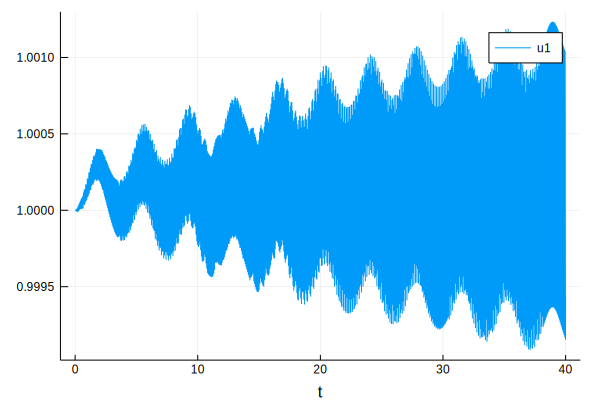

In [15]:
plot(sol.t,u1,xlabel="t",label="u1")

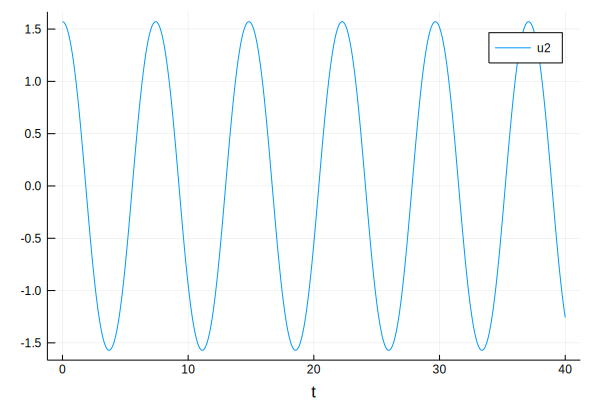

In [16]:
plot(sol.t,u2,xlabel="t",label="u2")

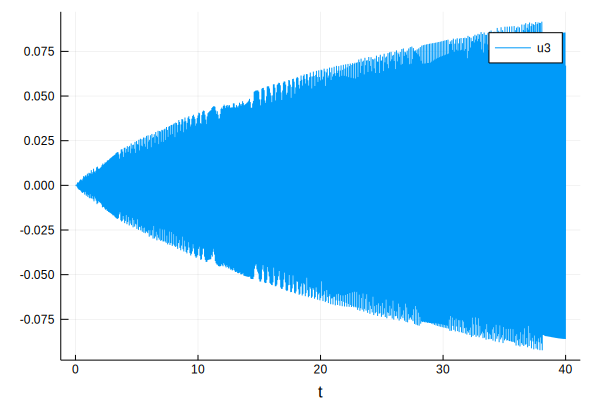

In [17]:
plot(sol.t,u3,xlabel="t",label="u3")

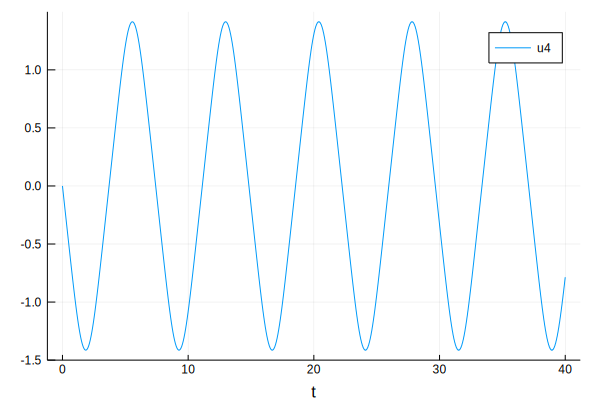

In [18]:
plot(sol.t,u4,xlabel="t",label="u4")

- Para comprobar la precisión de los resultados, **volver a aplicar DP5() al problema, pero esta vez con tol=$10^{-8}$. Antes que nada, comparar el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$.**

In [19]:
sol2 = solve(prob,DP5(),reltol=1e-8, abstol= 1e-8)

println(length(sol))
println(length(sol2))

3253
3416


- **Comentar el resultado**
>
> Con la introducion de C1 = 10000, el presente problema se ha convertido en un problema de tipo "stiff".
>
> Podemos observar que el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$ son muy parecidos (3253 para tol=$10^{-4}$ y 3416 para tol=$10^{-8}$), aunque hay 163 número de instantes del tiempo mas para tol=$10^{-8}$. 
>
>Como el resultado esperado seria una diferencia clara entre el numero de tiempos considerados para los dos niveles de tolerancia, este resultado indica que el algoritmo Dopri5 no es adecuado para resolver problemas del tipo "Stiff".

 
 - ** Representar gráficamente la evolución de la norma de los errores de los resultados obtenidos para tol=$10^{-4}$.**

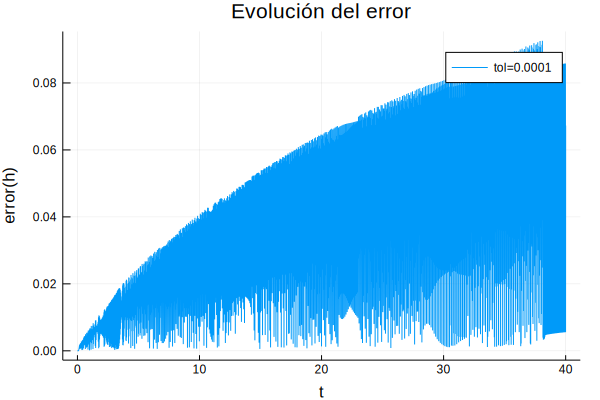

In [20]:
err = zeros(length(sol.t),1)
for ix in 1:length(sol.t)
    t = sol.t[ix]
    err[ix] = errfun(t)
end

plot(sol.t,err,xlabel="t",ylabel="error(h)",label="tol=$tol",title="Evolución del error")

- **Utilizar @btime para medir y comparar los tiempos de ejecución para los resultados obtenidos con tol=$10^{-4}$ y con tol=$10^{-8}$ respectivamente.**

In [21]:
@btime solve(prob,DP5(),reltol=1e-4, abstol= 1e-4)

  28.859 ms (475624 allocations: 41.58 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 3253-element Array{Float64,1}:
  0.0                
  0.07247796636776954
  0.10705539394530807
  0.14081930492700115
  0.16628377330123556
  0.19104968128445718
  0.21358506552873968
  0.2358108356518602 
  0.2582625225236316 
  0.2811273651790641 
  0.30159382573710064
  0.3224548827288859 
  0.3461657421730377 
  ⋮                  
 39.88640177814498   
 39.89727003265395   
 39.90866153550262   
 39.91780902936462   
 39.92867668574352   
 39.94007191047973   
 39.949195076016906  
 39.96006214570513   
 39.97145215612999   
 39.980604503965054  
 39.99147074741207   
 40.0                
u: 3253-element Array{Array{Float64,1},1}:
 [1.0, 1.5708, 0.0, 0.0]                     
 [0.999997, 1.56817, 4.0569e-5, -0.0724781]  
 [1.00001, 1.56507, 0.000256402, -0.107054]  
 [0.999992, 1.56088, -0.000791617, -0.140819]
 [1.00001, 1.55697, 0.00160394, -0.166279]   
 [1.00001, 1.55255, -0.00166334, -0.191041]  


In [22]:
@btime solve(prob,DP5(),reltol=1e-8, abstol= 1e-8)

  31.084 ms (489617 allocations: 42.80 MiB)


retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 3416-element Array{Float64,1}:
  0.0                 
  0.011486983549970353
  0.022051712266693876
  0.03708180383041603 
  0.05058652358825258 
  0.0627267830633034  
  0.07692399905417213 
  0.0916973559758118  
  0.10529025572033232 
  0.11750744669948752 
  0.12993648162751525 
  0.14498747325721836 
  0.15846729354036876 
  ⋮                   
 39.889713584153654   
 39.90092741898328    
 39.91058712527919    
 39.921172767156335   
 39.93333162665261    
 39.9429488616449     
 39.95440233355827    
 39.96515696889409    
 39.974984368663435   
 39.98572886694876    
 39.99716572748502    
 40.0                 
u: 3416-element Array{Array{Float64,1},1}:
 [1.0, 1.5708, 0.0, 0.0]                     
 [1.0, 1.57073, 7.08738e-7, -0.011487]       
 [1.0, 1.57055, 4.20091e-6, -0.0220517]      
 [1.0, 1.57011, 1.27574e-5, -0.0370818]      
 [1.0, 1.56952, 1.79997e-5, -0.0505865]      
 [1.0, 1.56883, 1.88

In [23]:
cput1 = 34.564
cput2 = 37.529

println(cput2/cput1)

1.0857828954982063


- **Comentar los resultados de tiempos de ejecución obtenidos.**
> 
> Podemos osbervar que los tiempos de ejecucion estan muy parecidos y practicamente iguales. Este resultado tambien no co-incide con el resultado esperado, y confirma que el algoritmo Dopri5 no esta adecuado para resolver problemas del tipo "Stiff".

<a href="#top">Back to the top</a>

### 4.2 - Método RK implícito de Hairer de orden 4 (Hairer4)

- **Aplicar Hairer4() con $tol=10^{-4}$, y representar gráficamente la evolución de las variables de estado con respecto del tiempo,  cada variable de estado en una figura diferente**.

In [24]:
u0= [1.,pi/2,0.,0.]
p= [1.,1.,10000,1,1]
tspan = (0.0,40.0)
prob = ODEProblem(fmuelle,u0,tspan,p);

In [25]:
sol = solve(prob,Hairer4(),reltol=1e-4, abstol= 1e-4)

u1 = [u[1] for (u,t) in tuples(sol)]
u2 = [u[2] for (u,t) in tuples(sol)]
u3 = [u[3] for (u,t) in tuples(sol)]
u4 = [u[4] for (u,t) in tuples(sol)]

106-element Array{Float64,1}:
  0.0                
 -0.03760602760844476
 -0.15202342101298963
 -0.29356067904821814
 -0.47106321035349324
 -0.6553567463726889 
 -0.8306603719359644 
 -1.0114530540631272 
 -1.2115502069198911 
 -1.3865709270775708 
 -1.3844798233911275 
 -1.2868291850067117 
 -1.1354394994479546 
  ⋮                  
  1.295317317794031  
  1.062646295476026  
  0.7246307050652927 
  0.31865876492834116
 -0.1383835669204409 
 -0.6622688667970317 
 -1.0935674260503974 
 -1.3293431369185622 
 -1.4151016895561668 
 -1.2955590058421127 
 -1.0628415858502374 
 -0.7893542167134586 

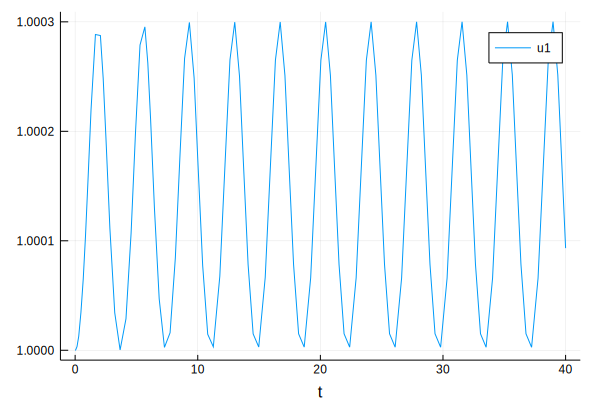

In [26]:
plot(sol.t,u1,xlabel="t",label="u1")

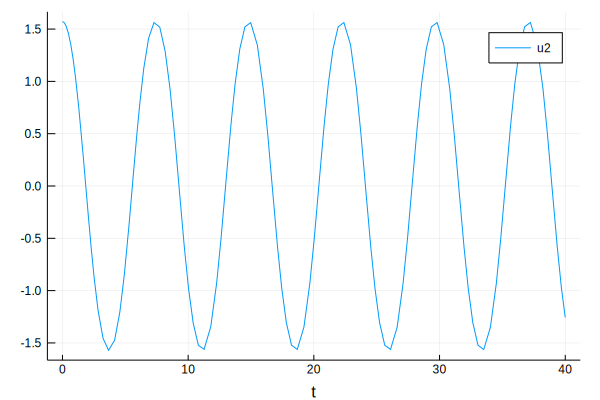

In [27]:
plot(sol.t,u2,xlabel="t",label="u2")

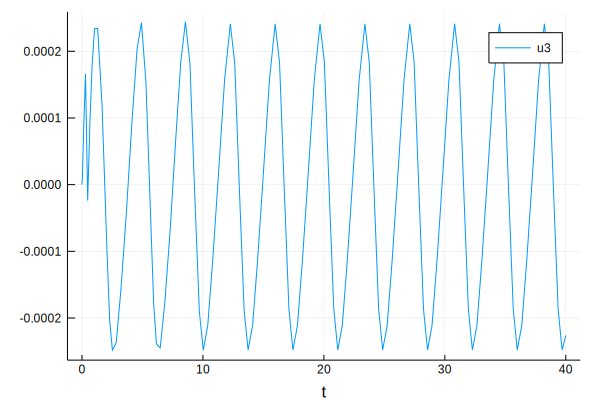

In [28]:
plot(sol.t,u3,xlabel="t",label="u3")

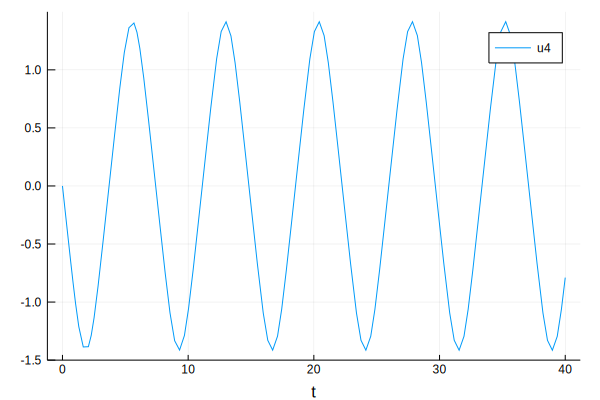

In [29]:
plot(sol.t,u4,xlabel="t",label="u4")

- Para comprobar la precisión de los resultados, **volver a aplicar Hairer4() al problema, pero esta vez con tol=$10^{-8}$. Antes que nada, comparar el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$.**

In [30]:
sol2 = solve(prob,Hairer4(),reltol=1e-8, abstol= 1e-8)

println(length(sol))
println(length(sol2))

106
5175


In [31]:
length(sol2)/length(sol)

48.820754716981135

- **Comentar el resultado, comparandolo con lo ocurrido en el caso de DP5**
>  
> Podemos observar que el número de instantes del tiempo considerados en los resultados obtenidos con tol=$10^{-8}$ es 5175 y que el  número de instantes del tiempo considerados en los resultados obtenidos con tol=$10^{-4}$ es 106. Este resultado es consistente con el incremento significativo que se espera en el numero de tiempos considerados con menor tolerancia del error.
> Por lo cual, podemos concluir que el algoritmo Hairer4 es adecuado para resolver problemas del tipo "stiff".
>

 
 - ** Representar gráficamente la evolución de la norma de los errores de los resultados obtenidos para tol=$10^{-4}$.**

In [32]:
err = zeros(length(sol.t),1)
for ix in 1:length(sol.t)
    t = sol.t[ix]
    err[ix] = errfun(t)
end

plot(sol.t,err,xlabel="t",ylabel="error(h)",label="tol=$tol",title="Evolución del error")
println(maximum(err))

0.004932740610310162


- **Utilizar @btime para medir y comparar los tiempos de ejecución para los resultados obtenidos con tol=$10^{-4}$ y con tol=$10^{-8}$ respectivamente.**

In [33]:
@btime solve(prob,Hairer4(),reltol=1e-4, abstol= 1e-4)

  1.833 ms (23569 allocations: 2.09 MiB)


retcode: Success
Interpolation: 3rd order Hermite
t: 106-element Array{Float64,1}:
  0.0                
  0.03760603093086394
  0.1520249267591619 
  0.2936008174575348 
  0.471834098743911  
  0.658622369893858  
  0.8412856000359538 
  1.0415902607350187 
  1.2990924240182014 
  1.655586129665022  
  2.060665813548997  
  2.2887046777675506 
  2.5149749515524227 
  ⋮                  
 35.65403838587542   
 35.98600803398161   
 36.35782725752615   
 36.76866800571726   
 37.22574911653057   
 37.75278303421334   
 38.22670053304463   
 38.587289889492446  
 38.97539660946805   
 39.36336196717215   
 39.69543584976091   
 40.0                
u: 106-element Array{Array{Float64,1},1}:
 [1.0, 1.5708, 0.0, 0.0]                     
 [1.0, 1.57009, 1.27702e-5, -0.037606]       
 [1.0, 1.55924, 8.97159e-5, -0.152023]       
 [1.00001, 1.5277, 0.000166041, -0.293561]   
 [1.00003, 1.45954, -2.38188e-5, -0.471063]  
 [1.00006, 1.35429, 9.35268e-5, -0.655357]   
 [1.0001, 1.21847, 0.000180

In [34]:
@btime solve(prob,Hairer4(),reltol=1e-8, abstol= 1e-8)

  140.854 ms (1237732 allocations: 111.22 MiB)


retcode: Success
Interpolation: 3rd order Hermite
t: 5175-element Array{Float64,1}:
  0.0                  
  0.0037606030930863936
  0.006703926889961161 
  0.0073812515677507354
  0.008654682295763568 
  0.012532037678280145 
  0.021221007715812465 
  0.031024124932848198 
  0.03392120786424693  
  0.036255873372660244 
  0.044373893062820934 
  0.05249191275298162  
  0.060870315133153496 
  ⋮                    
 39.91140361257823     
 39.91972057126515     
 39.9287652854312      
 39.93613902361247     
 39.94641862370053     
 39.95569987230085     
 39.96412075099965     
 39.96834465410376     
 39.97725594497826     
 39.985669940421246    
 39.99598637967627     
 40.0                  
u: 5175-element Array{Array{Float64,1},1}:
 [1.0, 1.5708, 0.0, 0.0]                     
 [1.0, 1.57079, 2.64059e-8, -0.0037606]      
 [1.0, 1.57077, 1.38276e-7, -0.00670393]     
 [1.0, 1.57077, 1.86641e-7, -0.00738125]     
 [1.0, 1.57076, 3.04988e-7, -0.00865468]     
 [1.0, 1.57072, 9.0

In [35]:
cput1 = 1.889
cput2 = 144.497

println(cput2/cput1)

76.49391212281631


- **Comentar los resultados de tiempos de ejecución obtenidos, comparandolos con los obtenidos con DP5.**
> 

> **Respuesta:**
>
> El tiempo de ejecucion obtenido para tol = 1e-4 es aprox. **2** ms.
>
> El tiempo de ejecucion obtenido para tol = 1e-8 es aprox. **145** ms.
>
> El resultado es consistente con el incremento significativo esperado en tiempo de ejecucion con menor tolerancia del error. Este resultado indica que el algoritmo Hairer4 es mas apropriado que el algoritmo DP5 para resolver el presente problema de tipo "Stiff", ya que no se podia observar una diferencia significativa en el tiempo de ejecucion con menor tolerancia del error para el algoritmo DP5 (el tiempo de ejecucion era casi igual para los dos niveles de tolerancia).

**¿Que podemos decir en cuanto a la eficiencia de los dos métodos, en este ejemplo con $C_1=10000$?**

>_Con $tol=10^{-4}$ y $C_1=10000$, se ha obtenido una mayor precisión con un número de pasos mas bajo con el algoritmo Hairer4 (106) frente al algoritmo DP4(3253)._

>_Con $tol=10^{-8}$ y $C_1=10000$, se ha obtenido una mayor precisión con un número de pasos mas alto con el algoritmo Hairer4 (5175) frente al algoritmo DP4(3416)._
>
>_**De modo que el algoritmo Hairer4 ha resultado cláramente más eficiente que el algoritmo DP5.**_

<a href="#top">Back to the top</a>

### Valoración

_Incluir aquí los comentarios de valoración de la tarea a entregar (dificultad, interés, etc, incluidas, si se quiere, sugerencias de mejora del ejercicio), así como una estimación del tiempo dedicado al trabajo de la semana (desglosado en el tiempo de estudio de material teórico, tiempo de dedicación a la participación activa o pasiva en los foros, tiempo de implementación y experimentación con los problemas prácticos planteados, y tiempo de preparación del documento jupyter final)._

> **dificultad:** atla !!!
>
> **interés:** alto!!! he apprendido mucho !!!
>
> **sugerencias de mejora del ejercicio**: los valores esperados ayudan mucho para encontrar errores. 
>
> **tiempo dedicado:**
> + tiempo de estudio material teorico: 2h
> + tiempo de dedicacion en el foro: 1 h
> + tiempo de implementacion y experimentacion: 8h
> + tiempo de preparacion del documento jupyter: 2h